In [ ]:
# Install TensorFlow with MAC M1 GPU support
# This script sets up a Python environment for deep learning with TensorFlow and PyTorch.
# It installs the necessary packages and verifies the installation by checking for GPU availability.
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

with tf.device('/GPU:0'):
    # Your TensorFlow code here
    pass


Num GPUs Available: 1


2025-03-30 23:28:41.359696: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-30 23:28:41.359726: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-30 23:28:41.359734: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-30 23:28:41.359802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-30 23:28:41.359842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('../Assignment_MIMIC_SQL/database.db')

# Test DB Connection and Query
try:
    conn.execute("SELECT 1")
    print("Connection to database successful.")
except sqlite3.Error as e:
    print(f"Error connecting to database: {e}")

# Close the connection
conn.close()

Connection to database successful.


In [6]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime

# Connect to the SQLite database
conn = sqlite3.connect('../Assignment_MIMIC_SQL/database.db')

# Get list of tables in database to understand its structure
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:", [table[0] for table in tables])

# Extract admissions data
admissions_query = """
SELECT 
    SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME, ADMISSION_TYPE, 
    ADMISSION_LOCATION, DISCHARGE_LOCATION, INSURANCE, LANGUAGE, RELIGION,
    MARITAL_STATUS, ETHNICITY
FROM ADMISSIONS
"""
admissions = pd.read_sql_query(admissions_query, conn)

# Convert dates safely
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], errors='coerce')
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'], errors='coerce')

# Drop rows with invalid dates
admissions = admissions.dropna(subset=['ADMITTIME', 'DISCHTIME'])
admissions = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])

# Calculate days until next admission for each patient
admissions['NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
admissions['DAYS_NEXT_ADMIT'] = (admissions['NEXT_ADMITTIME'] - admissions['DISCHTIME']).dt.total_seconds() / (24 * 3600)

# Create target variable (1 if readmitted within 30 days)
admissions['READMISSION_30'] = (admissions['DAYS_NEXT_ADMIT'] <= 30) & (admissions['DAYS_NEXT_ADMIT'] >= 0)
admissions['READMISSION_30'] = admissions['READMISSION_30'].astype(int)

# Get patient demographics
patients_query = "SELECT SUBJECT_ID, GENDER, DOB, DOD FROM PATIENTS"
patients = pd.read_sql_query(patients_query, conn)

# Convert DOB safely and handle date arithmetic more carefully
patients['DOB'] = pd.to_datetime(patients['DOB'], errors='coerce')
patients = patients.dropna(subset=['DOB'])

# Join with admissions
admissions_demo = admissions.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID')

# Calculate age more safely using a custom function
def calculate_age(row):
    try:
        # Use year difference as an approximation to avoid overflow
        years_diff = row['ADMITTIME'].year - row['DOB'].year
        # Adjust for not having had birthday yet that year
        if (row['ADMITTIME'].month, row['ADMITTIME'].day) < (row['DOB'].month, row['DOB'].day):
            years_diff -= 1
        return min(years_diff, 90)  # Cap at 90 for de-identification
    except:
        return np.nan

# Apply the function
admissions_demo['AGE'] = admissions_demo.apply(calculate_age, axis=1)

# Calculate length of stay
admissions_demo['LOS'] = (admissions_demo['DISCHTIME'] - admissions_demo['ADMITTIME']).dt.total_seconds() / (24 * 3600)

# Get count of previous admissions
admissions_demo['PREV_ADMISSIONS'] = admissions.groupby('SUBJECT_ID').cumcount()

# Get top diagnoses
diagnoses_query = """
SELECT D.SUBJECT_ID, D.HADM_ID, D.ICD9_CODE, D.SEQ_NUM
FROM DIAGNOSES_ICD D
JOIN ADMISSIONS A ON D.HADM_ID = A.HADM_ID
ORDER BY D.SUBJECT_ID, A.ADMITTIME, D.SEQ_NUM
"""
diagnoses = pd.read_sql_query(diagnoses_query, conn)

# Get top 10 most common diagnoses
top_diagnoses = diagnoses['ICD9_CODE'].value_counts().head(10).index
print("Top diagnoses:", top_diagnoses.tolist())

# Create binary features for top diagnoses
for code in top_diagnoses:
    diagnoses_pivot = diagnoses[diagnoses['ICD9_CODE'] == code].pivot_table(
        index='HADM_ID', values='ICD9_CODE', aggfunc='count'
    ).reset_index()
    diagnoses_pivot.columns = ['HADM_ID', f'DIAG_{code}']
    diagnoses_pivot[f'DIAG_{code}'] = 1
    admissions_demo = admissions_demo.merge(diagnoses_pivot, on='HADM_ID', how='left')
    admissions_demo[f'DIAG_{code}'] = admissions_demo[f'DIAG_{code}'].fillna(0)

# Get top procedures
procedures_query = """
SELECT P.SUBJECT_ID, P.HADM_ID, P.ICD9_CODE, P.SEQ_NUM
FROM PROCEDURES_ICD P
JOIN ADMISSIONS A ON P.HADM_ID = A.HADM_ID
ORDER BY P.SUBJECT_ID, A.ADMITTIME, P.SEQ_NUM
"""
procedures = pd.read_sql_query(procedures_query, conn)

# Get top 10 most common procedures
top_procedures = procedures['ICD9_CODE'].value_counts().head(10).index
print("Top procedures:", top_procedures.tolist())

# Create binary features for top procedures
for code in top_procedures:
    procedures_pivot = procedures[procedures['ICD9_CODE'] == code].pivot_table(
        index='HADM_ID', values='ICD9_CODE', aggfunc='count'
    ).reset_index()
    procedures_pivot.columns = ['HADM_ID', f'PROC_{code}']
    procedures_pivot[f'PROC_{code}'] = 1
    admissions_demo = admissions_demo.merge(procedures_pivot, on='HADM_ID', how='left')
    admissions_demo[f'PROC_{code}'] = admissions_demo[f'PROC_{code}'].fillna(0)

# Extract lab results and vital signs - with safer error handling
try:
    # Try getting vital signs from CHARTEVENTS if available
    vital_signs_check = """
    SELECT name FROM sqlite_master WHERE type='table' AND name='CHARTEVENTS';
    """
    chart_exists = pd.read_sql_query(vital_signs_check, conn)
    
    if not chart_exists.empty:
        vital_items = {
            '211': 'HR',      # Heart Rate
            '220045': 'BP_SYS',  # Systolic BP
            '220050': 'BP_DIA',  # Diastolic BP
            '223761': 'TEMP'    # Temperature
        }
        
        # Try with string concatenation
        vitals_query = f"""
        SELECT C.SUBJECT_ID, C.HADM_ID, C.ITEMID, C.CHARTTIME, C.VALUENUM
        FROM CHARTEVENTS C
        WHERE C.ITEMID IN ({','.join(vital_items.keys())})
        AND C.VALUENUM IS NOT NULL
        ORDER BY C.SUBJECT_ID, C.HADM_ID, C.CHARTTIME
        """
        vitals = pd.read_sql_query(vitals_query, conn)
        print(f"Found {len(vitals)} vital sign measurements")
        
        # Get lab results if LABEVENTS table exists
        lab_check = """
        SELECT name FROM sqlite_master WHERE type='table' AND name='LABEVENTS';
        """
        lab_exists = pd.read_sql_query(lab_check, conn)
        
        if not lab_exists.empty:
            lab_items = {
                '50912': 'CREATININE',
                '51006': 'BUN',
                '51300': 'WBC',
                '51222': 'HEMOGLOBIN'
            }
            
            labs_query = f"""
            SELECT L.SUBJECT_ID, L.HADM_ID, L.ITEMID, L.CHARTTIME, L.VALUENUM
            FROM LABEVENTS L
            WHERE L.ITEMID IN ({','.join(lab_items.keys())})
            AND L.VALUENUM IS NOT NULL
            ORDER BY L.SUBJECT_ID, L.HADM_ID, L.CHARTTIME
            """
            labs = pd.read_sql_query(labs_query, conn)
            print(f"Found {len(labs)} lab measurements")
            
            # Function to get the last measurement for each admission
            def get_last_measurement(events_df, items_dict):
                result = pd.DataFrame()
                for item_id, col_name in items_dict.items():
                    item_events = events_df[events_df['ITEMID'] == int(item_id)]
                    if len(item_events) > 0:
                        # Get last value before discharge for each admission
                        item_events['CHARTTIME'] = pd.to_datetime(item_events['CHARTTIME'], errors='coerce')
                        item_events = item_events.dropna(subset=['CHARTTIME'])
                        last_values = item_events.sort_values('CHARTTIME').groupby('HADM_ID').last()[['VALUENUM']].reset_index()
                        last_values.columns = ['HADM_ID', col_name]
                        
                        if result.empty:
                            result = last_values
                        else:
                            result = result.merge(last_values, on='HADM_ID', how='outer')
                return result
            
            # Get vital signs and lab results
            vitals_features = get_last_measurement(vitals, vital_items)
            labs_features = get_last_measurement(labs, lab_items)
            
            # Merge vitals and labs with admissions
            if not vitals_features.empty:
                admissions_demo = admissions_demo.merge(vitals_features, on='HADM_ID', how='left')
            if not labs_features.empty:
                admissions_demo = admissions_demo.merge(labs_features, on='HADM_ID', how='left')
        else:
            print("LABEVENTS table not found")
    else:
        print("CHARTEVENTS table not found")
except sqlite3.Error as e:
    print(f"Error querying vitals or labs: {e}")
    print("Continuing without vitals or labs data")

# Check for ICU stays as a feature
try:
    icu_check = """
    SELECT name FROM sqlite_master WHERE type='table' AND name='ICUSTAYS';
    """
    icu_exists = pd.read_sql_query(icu_check, conn)
    
    if not icu_exists.empty:
        icu_query = """
        SELECT SUBJECT_ID, HADM_ID, COUNT(*) as ICU_STAYS
        FROM ICUSTAYS
        GROUP BY SUBJECT_ID, HADM_ID
        """
        icu_stays = pd.read_sql_query(icu_query, conn)
        admissions_demo = admissions_demo.merge(icu_stays, on=['SUBJECT_ID', 'HADM_ID'], how='left')
        admissions_demo['ICU_STAYS'] = admissions_demo['ICU_STAYS'].fillna(0)
    else:
        print("ICUSTAYS table not found")
except sqlite3.Error as e:
    print(f"Error querying ICU stays: {e}")
    print("Continuing without ICU stays data")

# Handle missing values
numeric_cols = admissions_demo.select_dtypes(include=['float64', 'int64']).columns.tolist()
admissions_demo[numeric_cols] = admissions_demo[numeric_cols].fillna(admissions_demo[numeric_cols].median())

# Drop rows with missing values that couldn't be imputed
admissions_demo = admissions_demo.dropna(subset=['AGE', 'LOS'])

# Select features for model
feature_cols = [col for col in numeric_cols if col not in ['SUBJECT_ID', 'HADM_ID', 'NEXT_ADMITTIME', 
                                                         'DAYS_NEXT_ADMIT', 'READMISSION_30']]

# Encode categorical variables
cat_cols = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS']
for col in cat_cols:
    if col in admissions_demo.columns:
        # Check if column has enough non-null values
        if admissions_demo[col].count() > len(admissions_demo) * 0.5:  # At least 50% non-null
            dummies = pd.get_dummies(admissions_demo[col], prefix=col, drop_first=True)
            admissions_demo = pd.concat([admissions_demo, dummies], axis=1)
            feature_cols.extend(dummies.columns.tolist())

# Print feature list for review
print(f"Selected features: {feature_cols}")
print(f"Total features: {len(feature_cols)}")

# Final dataset for modeling
X = admissions_demo[feature_cols]
y = admissions_demo['READMISSION_30']

# Check for class imbalance
class_distribution = y.value_counts(normalize=True)
print(f"Class distribution: {class_distribution}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Close database connection
conn.close()

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Number of readmissions in training data: {sum(y_train == 1)}")
print(f"Number of non-readmissions in training data: {sum(y_train == 0)}")

Tables in database: ['PROCEDUREEVENTS_MV', 'CALLOUT', 'D_CPT', 'D_ITEMS', 'CAREGIVERS', 'MICROBIOLOGYEVENTS', 'LABEVENTS', 'INPUTEVENTS_CV', 'ADMISSIONS', 'D_LABITEMS', 'DATETIMEEVENTS', 'PRESCRIPTIONS', 'PROCEDURES_ICD', 'NOTEEVENTS', 'CHARTEVENTS', 'TRANSFERS', 'DIAGNOSES_ICD', 'SERVICES', 'DRGCODES', 'OUTPUTEVENTS', 'PATIENTS', 'D_ICD_DIAGNOSES', 'ICUSTAYS', 'INPUTEVENTS_MV', 'D_ICD_PROCEDURES', 'CPTEVENTS']
Top diagnoses: ['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081']
Top procedures: [3893, 9604, 966, 9671, 9904, 3961, 9672, 9955, 8856, 3891]
Found 9613519 vital sign measurements
Found 2343672 lab measurements


/var/folders/_c/ggv3f7q50ljf06zfzw29jmfh0000gn/T/ipykernel_13058/1053928865.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_events['CHARTTIME'] = pd.to_datetime(item_events['CHARTTIME'], errors='coerce')
/var/folders/_c/ggv3f7q50ljf06zfzw29jmfh0000gn/T/ipykernel_13058/1053928865.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_events['CHARTTIME'] = pd.to_datetime(item_events['CHARTTIME'], errors='coerce')
/var/folders/_c/ggv3f7q50ljf06zfzw29jmfh0000gn/T/ipykernel_13058/1053928865.py:180

Selected features: ['AGE', 'LOS', 'PREV_ADMISSIONS', 'DIAG_4019', 'DIAG_4280', 'DIAG_42731', 'DIAG_41401', 'DIAG_5849', 'DIAG_25000', 'DIAG_2724', 'DIAG_51881', 'DIAG_5990', 'DIAG_53081', 'PROC_3893', 'PROC_9604', 'PROC_966', 'PROC_9671', 'PROC_9904', 'PROC_3961', 'PROC_9672', 'PROC_9955', 'PROC_8856', 'PROC_3891', 'HR', 'BP_SYS', 'BP_DIA', 'TEMP', 'CREATININE', 'BUN', 'WBC', 'HEMOGLOBIN', 'ICU_STAYS', 'GENDER_M', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED']
Total features: 46
Class distribution: READMISSION_30
0    0.942756
1    0.057244
Name: proportion, dtype: float64
Training data shape: (47180, 46)
Number of readmissions in training data: 2701
Number of non-readmissions in training data: 44479

Class weights: {0: 1.0, 1: 16.46760459089226}


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3008      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

2025-03-31 09:08:14.761234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1180/1180 [==============================] - ETA: 0s - loss: 1.4283 - accuracy: 0.5539 - auc: 0.5978 - precision: 0.0766 - recall: 0.5971

2025-03-31 09:08:31.695610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_auc improved from -inf to 0.62142, saving model to best_readmission_model.h5
1180/1180 [==============================] - 20s 15ms/step - loss: 1.4283 - accuracy: 0.5539 - auc: 0.5978 - precision: 0.0766 - recall: 0.5971 - val_loss: 0.7503 - val_accuracy: 0.5749 - val_auc: 0.6214 - val_precision: 0.0719 - val_recall: 0.6078 - lr: 0.0010
Epoch 2/50
  10/1180 [..............................] - ETA: 14s - loss: 1.4426 - accuracy: 0.5688 - auc: 0.5364 - precision: 0.0526 - recall: 0.3684

/opt/homebrew/Caskroom/miniconda/base/envs/ai_health/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1176/1180 [============================>.] - ETA: 0s - loss: 1.3545 - accuracy: 0.5712 - auc: 0.6268 - precision: 0.0816 - recall: 0.6149
Epoch 2: val_auc improved from 0.62142 to 0.63470, saving model to best_readmission_model.h5
1180/1180 [==============================] - 17s 14ms/step - loss: 1.3544 - accuracy: 0.5710 - auc: 0.6265 - precision: 0.0815 - recall: 0.6147 - val_loss: 0.7534 - val_accuracy: 0.5549 - val_auc: 0.6347 - val_precision: 0.0721 - val_recall: 0.6427 - lr: 0.0010
Epoch 3/50
1178/1180 [============================>.] - ETA: 0s - loss: 1.3326 - accuracy: 0.5669 - auc: 0.6341 - precision: 0.0820 - recall: 0.6262
Epoch 3: val_auc did not improve from 0.63470
1180/1180 [==============================] - 17s 14ms/step - loss: 1.3325 - accuracy: 0.5669 - auc: 0.6345 - precision: 0.0821 - recall: 0.6269 - val_loss: 0.7341 - val_accuracy: 0.5558 - val_auc: 0.6339 - val_precision: 0.0746 - val_recall: 0.6674 - lr: 0.0010
Epoch 4/50
1178/1180 [============================

2025-03-31 09:15:52.698359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 0s 1ms/step

Confusion Matrix:
[[6363 4758]
 [ 236  439]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.57      0.72     11121
           1       0.08      0.65      0.15       675

    accuracy                           0.58     11796
   macro avg       0.52      0.61      0.43     11796
weighted avg       0.91      0.58      0.69     11796



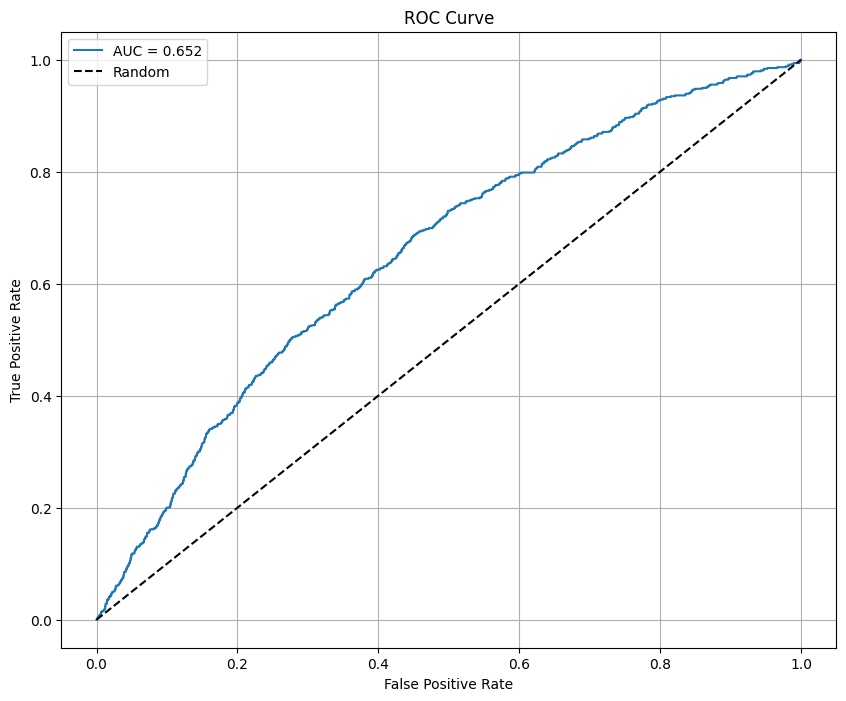

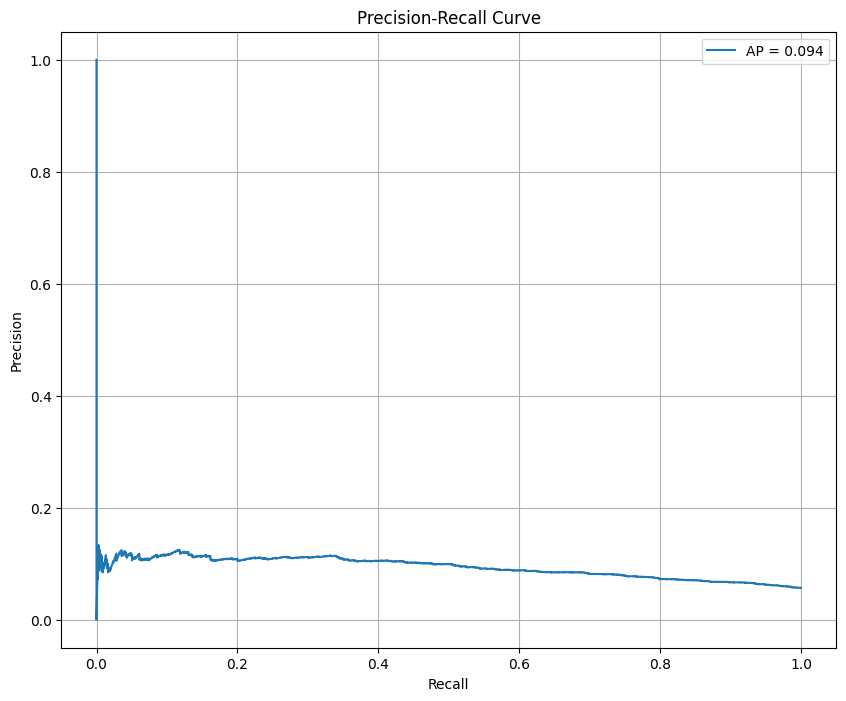

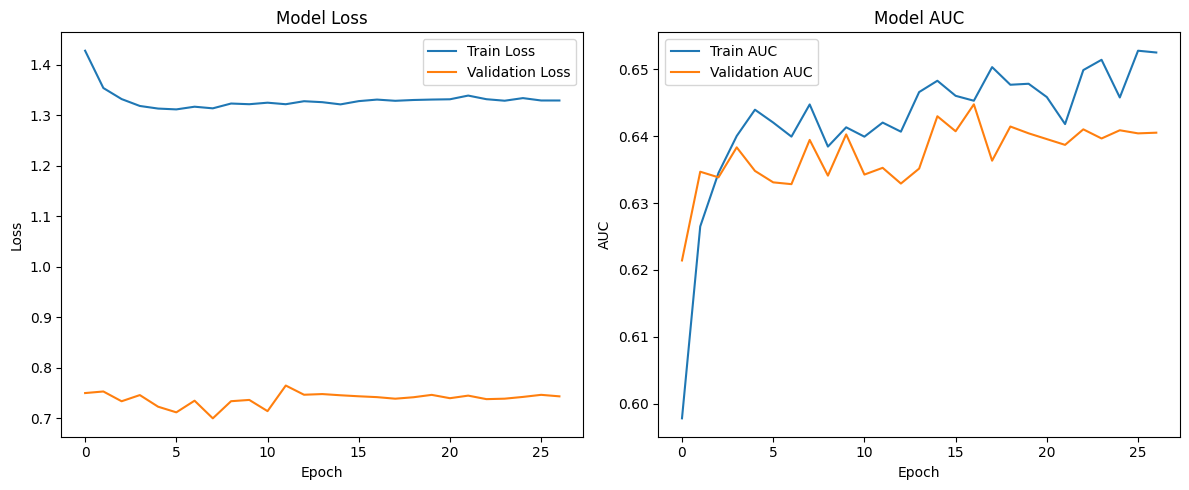

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

# Check if we have enough features and samples
if X_train_scaled.shape[1] == 0:
    raise ValueError("No features available for training")
    
if X_train_scaled.shape[0] < 100:
    raise ValueError("Not enough samples for training")

# Calculate class weights for imbalanced dataset
pos_count = sum(y_train == 1)
neg_count = sum(y_train == 0)

if pos_count == 0 or neg_count == 0:
    print("Warning: One class has zero samples. Using balanced class weights.")
    class_weights = {0: 1.0, 1: 1.0}
else:
    class_weights = {0: 1.0, 1: neg_count / pos_count}

print(f"Class weights: {class_weights}")

# Build the neural network model
model = Sequential([
    # Input layer
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), 
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Hidden layers
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile model with Adam optimizer and learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Show model summary
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_readmission_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model with error handling
try:
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=50,  # Reduced for initial testing
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
except Exception as e:
    print(f"Error during model training: {e}")
    # Try with smaller batch size and simpler model if error occurs
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=30,
        batch_size=16,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )

# Evaluate on test set
test_results = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")

# Generate predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Try to calculate ROC AUC (may fail if only one class is predicted)
try:
    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error plotting ROC curve: {e}")

# Try to plot precision-recall curve
try:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error plotting precision-recall curve: {e}")

# Plot training history
try:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting training history: {e}")


Top 20 Important Features (Random Forest):
                     feature  importance
1                        LOS    0.118599
30                HEMOGLOBIN    0.100257
23                        HR    0.088187
0                        AGE    0.084015
28                       BUN    0.083033
27                CREATININE    0.069637
24                    BP_SYS    0.049913
26                      TEMP    0.043131
25                    BP_DIA    0.024738
2            PREV_ADMISSIONS    0.023153
31                 ICU_STAYS    0.020491
32                  GENDER_M    0.016836
3                  DIAG_4019    0.014422
41    MARITAL_STATUS_MARRIED    0.012892
13                 PROC_3893    0.012338
5                 DIAG_42731    0.011877
4                  DIAG_4280    0.011524
33  ADMISSION_TYPE_EMERGENCY    0.011428
43     MARITAL_STATUS_SINGLE    0.011331
8                 DIAG_25000    0.010851


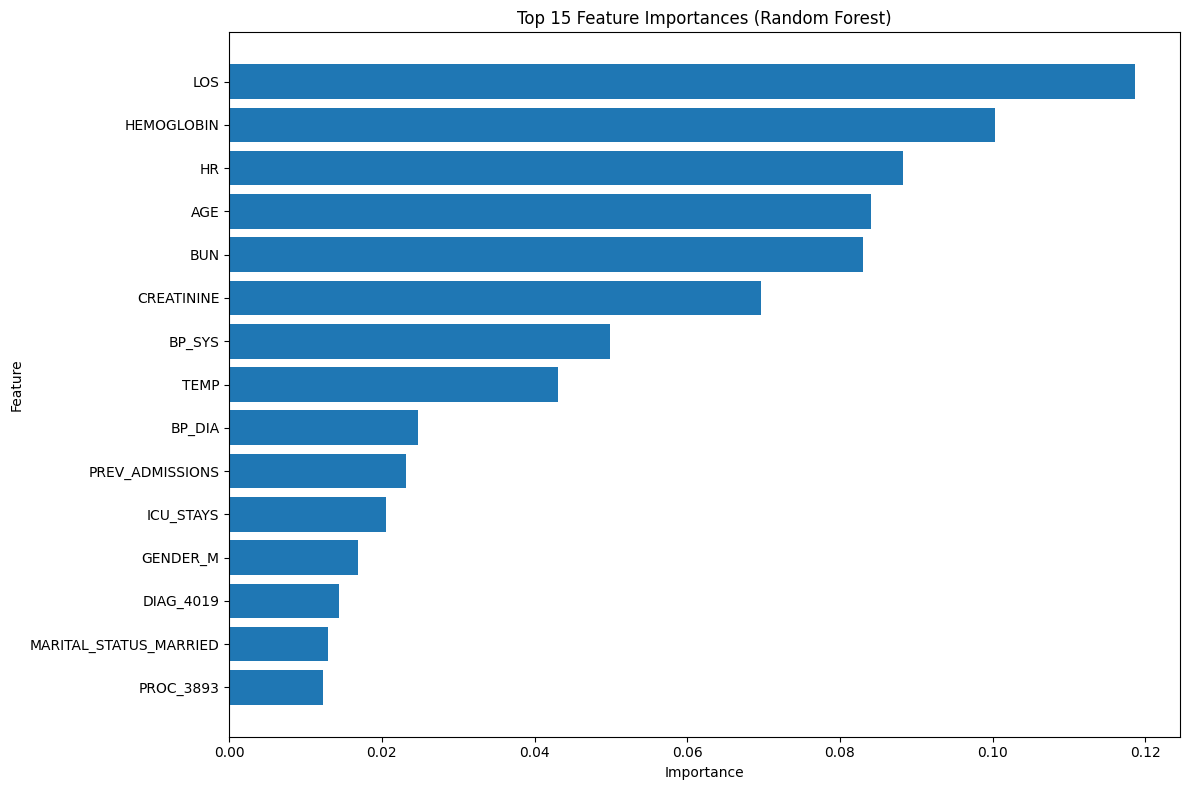


Calculating custom permutation importance (this may take a while)...
16/16 [==============================] - 0s 1ms/step

Top 20 Features by Permutation Importance (Neural Network):
                     feature  importance       std
30                HEMOGLOBIN    0.028872  0.008904
21                 PROC_8856    0.021450  0.009116
18                 PROC_3961    0.020369  0.010490
24                    BP_SYS    0.020122  0.002359
27                CREATININE    0.018793  0.001986
20                 PROC_9955    0.015746  0.011253
37        INSURANCE_Medicare    0.013267  0.005241
36        INSURANCE_Medicaid    0.012487  0.003640
1                        LOS    0.012045  0.002811
43     MARITAL_STATUS_SINGLE    0.011726  0.006756
33  ADMISSION_TYPE_EMERGENCY    0.011318  0.009287
7                  DIAG_5849    0.007422  0.001086
13                 PROC_3893    0.006819  0.003688
11                 DIAG_5990    0.004836  0.000584
28                       BUN    0.004446  0.003361


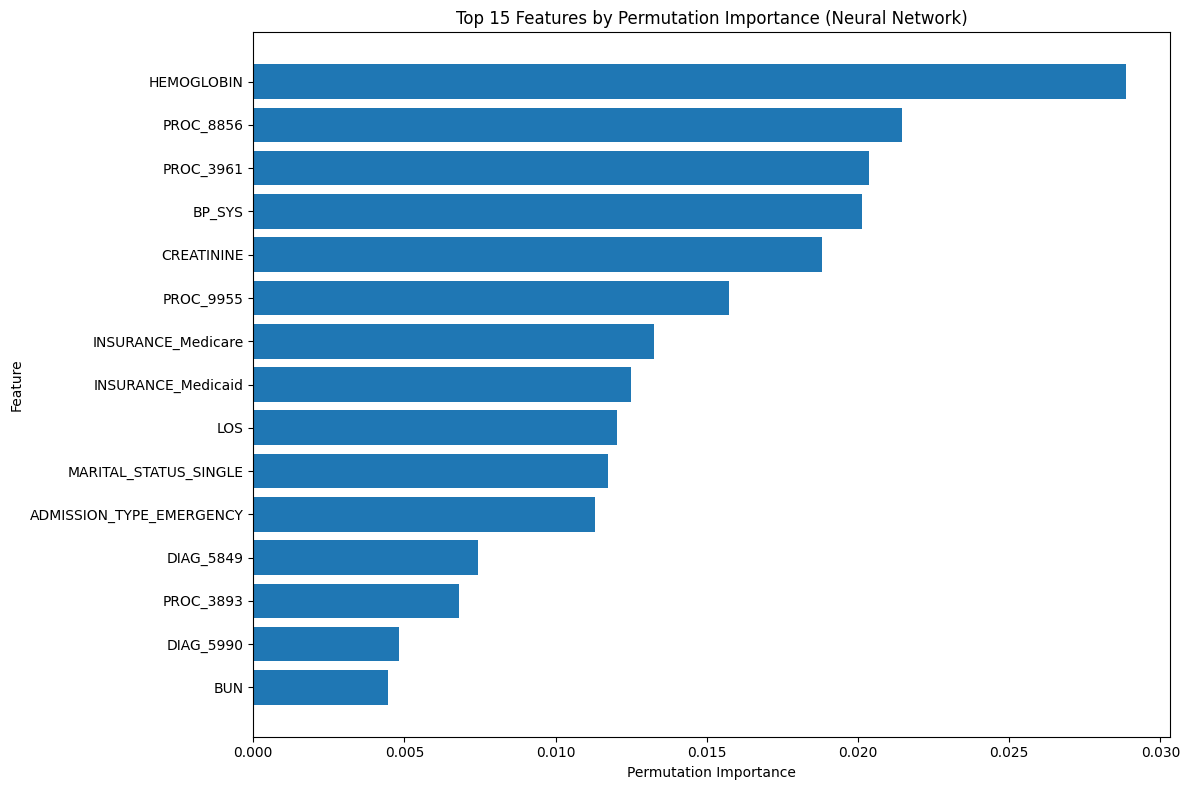

In [ ]:
# Feature importance analysis using widely compatible methods
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Train a random forest for feature importance (as a baseline model)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
rf_model.fit(X_train, y_train)

# Get feature importances from Random Forest
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Print top 20 features
print("\nTop 20 Important Features (Random Forest):")
print(feature_importances.head(20))

# Plot feature importances
plt.figure(figsize=(12, 8))
top_features = feature_importances.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # Invert to have highest at the top
plt.tight_layout()
plt.show()

# Custom permutation importance implementation
# This works with any sklearn version
try:
    def calculate_permutation_importance(model, X, y, metric='auc', n_repeats=5):
        """Calculate permutation importance manually."""
        from sklearn.metrics import roc_auc_score
        import numpy as np
        
        # Get baseline score
        X_scaled = scaler.transform(X) if 'scaler' in globals() else X
        preds = model.predict_proba(X_scaled)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_scaled)
        baseline_score = roc_auc_score(y, preds)
        
        importances = np.zeros(X.shape[1])
        importances_std = np.zeros(X.shape[1])
        
        for i in range(X.shape[1]):
            importance_scores = []
            for j in range(n_repeats):
                # Create a copy of the data
                X_permuted = X.copy()
                # Permute one feature
                X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i].values)
                # Score with permuted feature
                X_scaled_perm = scaler.transform(X_permuted) if 'scaler' in globals() else X_permuted
                preds_permuted = model.predict_proba(X_scaled_perm)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_scaled_perm)
                score_permuted = roc_auc_score(y, preds_permuted)
                # Calculate importance (decrease in performance)
                importance = baseline_score - score_permuted
                importance_scores.append(importance)
            
            importances[i] = np.mean(importance_scores)
            importances_std[i] = np.std(importance_scores)
        
        return importances, importances_std
    
    # Calculate permutation importance on a subset for efficiency
    print("\nCalculating custom permutation importance (this may take a while)...")
    subset_size = min(500, len(X_test))
    X_subset = X_test.iloc[:subset_size]
    y_subset = y_test.iloc[:subset_size]
    
    perm_importances_mean, perm_importances_std = calculate_permutation_importance(
        model=model,  # Your neural network model
        X=X_subset,
        y=y_subset,
        n_repeats=3  # Reduced for speed
    )
    
    # Get permutation importances
    perm_importances = pd.DataFrame({
        'feature': feature_cols,
        'importance': perm_importances_mean,
        'std': perm_importances_std
    }).sort_values('importance', ascending=False)
    
    # Print top 20 features based on permutation importance
    print("\nTop 20 Features by Permutation Importance (Neural Network):")
    print(perm_importances.head(20))
    
    # Plot permutation importances
    plt.figure(figsize=(12, 8))
    top_perm_features = perm_importances.head(15)
    plt.barh(top_perm_features['feature'], top_perm_features['importance'])
    plt.xlabel('Permutation Importance')
    plt.ylabel('Feature')
    plt.title('Top 15 Features by Permutation Importance (Neural Network)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error calculating permutation importance: {e}")
    print("Using only Random Forest feature importance instead.")

Threshold: 0.10, F1: 0.1083, Precision: 0.0572, Recall: 1.0000
Threshold: 0.15, F1: 0.1083, Precision: 0.0572, Recall: 1.0000
Threshold: 0.20, F1: 0.1081, Precision: 0.0572, Recall: 0.9970
Threshold: 0.25, F1: 0.1083, Precision: 0.0573, Recall: 0.9941
Threshold: 0.30, F1: 0.1105, Precision: 0.0585, Recall: 0.9852
Threshold: 0.35, F1: 0.1157, Precision: 0.0616, Recall: 0.9630
Threshold: 0.40, F1: 0.1243, Precision: 0.0667, Recall: 0.9141
Threshold: 0.45, F1: 0.1333, Precision: 0.0727, Recall: 0.7985
Threshold: 0.50, F1: 0.1495, Precision: 0.0845, Recall: 0.6504
Threshold: 0.55, F1: 0.1659, Precision: 0.1010, Recall: 0.4637
Threshold: 0.60, F1: 0.1496, Precision: 0.1093, Recall: 0.2370
Threshold: 0.65, F1: 0.0947, Precision: 0.1129, Recall: 0.0815
Threshold: 0.70, F1: 0.0276, Precision: 0.0902, Recall: 0.0163
Threshold: 0.75, F1: 0.0058, Precision: 0.1250, Recall: 0.0030
Threshold: 0.80, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Threshold: 0.85, F1: 0.0000, Precision: 0.0000, Recall:

/opt/homebrew/Caskroom/miniconda/base/envs/ai_health/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/homebrew/Caskroom/miniconda/base/envs/ai_health/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


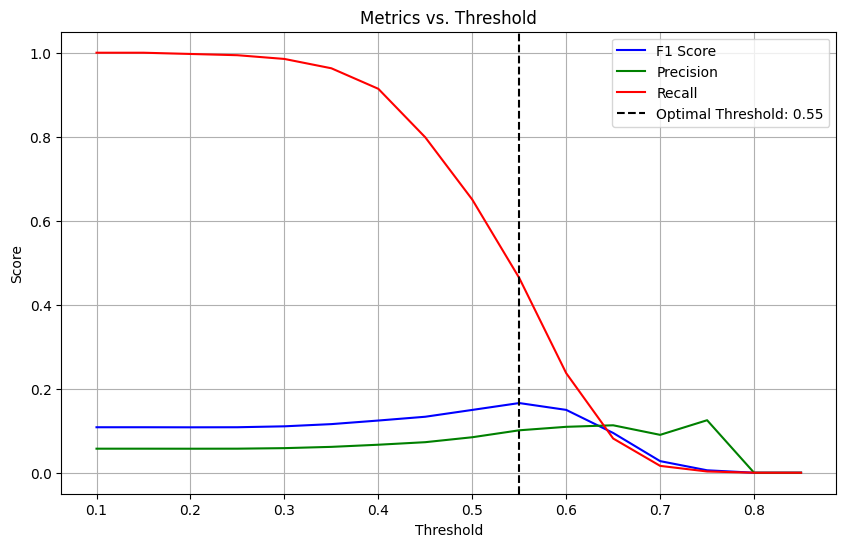


Confusion Matrix with Optimal Threshold:
[[8335 2786]
 [ 362  313]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     11121
           1       0.10      0.46      0.17       675

    accuracy                           0.73     11796
   macro avg       0.53      0.61      0.50     11796
weighted avg       0.91      0.73      0.80     11796



In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Find optimal threshold based on F1 score
try:
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        
        print(f"Threshold: {threshold:.2f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Get optimal threshold
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold: {optimal_threshold:.2f}")
    print(f"F1 Score: {f1_scores[optimal_idx]:.4f}")
    print(f"Precision: {precision_scores[optimal_idx]:.4f}") 
    print(f"Recall: {recall_scores[optimal_idx]:.4f}")

    # Plot threshold vs metrics
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'b-', label='F1 Score')
    plt.plot(thresholds, precision_scores, 'g-', label='Precision')
    plt.plot(thresholds, recall_scores, 'r-', label='Recall')
    plt.axvline(x=optimal_threshold, color='k', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Metrics vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate model with optimal threshold
    y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    print("\nConfusion Matrix with Optimal Threshold:")
    print(cm_optimal)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))
except Exception as e:
    print(f"Error finding optimal threshold: {e}")